# Monthly profits [same month with unemployeement announce] (y-axis) vs unemployeement rate (x-axis) by scatter plot using BLS API

## Question
Do unemployment rate announcement affect the monthly profit of NASDAQ-100 (NDX) Index?

## Null hypothesis
Unemployment rate announcement does not affect the monthly profit of NDX.

## Analysis
- The **Pearson’s correlation coefficient** between the unemployment rate announcement and the monthly profit of NDX is **-0.12**. This value indicates a **very weak or negligible correlation**, as it falls below the threshold of **0.3** for a meaningful relationship. Consequently, we can infer that there is **no significant correlation** between these two variables.

- The **p-value** associated with this correlation is **0.18**. Since this value exceeds the common significance level of **0.05**, we lack sufficient evidence to **reject the null hypothesis**. In simpler terms, the observed effect could plausibly occur by chance, and we cannot confidently assert a causal relationship between unemployment rate announcements and NDX monthly profits.

- The **coefficient of determination (r-squared)**, which quantifies the proportion of variance in NDX profits explained by the unemployment rate, is **0.02**. This low value suggests that the linear relationship between these variables is **minimal** or **nonexistent**.

- In summary, while we find no significant correlation between unemployment rate announcements and NDX monthly profits, it remains inconclusive whether the rate directly impacts profits. To gain deeper insights, consider conducting additional studies that explore other macroeconomic indicators and their potential relationships with stock market performance.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint

# Import common modules
# from Common_Stockdata import get_stock_data
from Common_Module.Common_Unemploymentdata import get_unemployment_data

# Import the API key
from api_keys import bls_api_key, alpha_vantage_api_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

# Part 1: Extract unemployment data frame from common module

In [2]:
# Load the unemployment rate DataFrame using the function from your module
unemployment_data_df = get_unemployment_data()

# Convert data types as required
unemployment_data_df['Year'] = unemployment_data_df['Year'].astype(int)

##### Optional: Find monthly unemployment data in US (without common module)

U.S.Bureau of Labor Statistics (BLS)
Refer to https://www.bls.gov/developers/home.htm for BLS API webpage. Referencing BLS data, extract unemployment data for the past decade from 2013 till 2024 and plot a scatter plot.

Identify Series ID for unemployment rate
Referencing https://beta.bls.gov/dataQuery/find?q=unemployment to find series ID info for unemployment.

Required series ID is **LNS14000000**.

In [3]:
# # Set base url
# base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# # Set parameters
# seriesid = 'LNS14000000'
# startyear = 2013
# endyear = 2023
# registrationkey = bls_api_key

# # Create parameter dictionary
# params = {'seriesid':[seriesid],
#           'startyear':startyear,
#           'endyear':endyear,
#           'registrationkey':registrationkey}

# # Run a request and return response
# response = requests.post(base_url, json=params)

# # Convert response to json
# response_json = response.json()

In [4]:
# # set up list to hold reponse info
# unemployment_data = []

# # Loop through the list of unemployment data and store data on each year in a list
# unemployment_years = response_json['Results']['series'][0]['data']

# for list in unemployment_years:
    
#     unemployment_data.append({'Year': list['year'],
#                               'Month': list['periodName'],
#                               'Rate': list['value']})

# # Create data frame based on collected list
# unemployment_df = pd.DataFrame(unemployment_data)

# # Convert columns type
# unemployment_df['Rate'] = unemployment_df['Rate'].astype(float)
# unemployment_df['Year'] = unemployment_df['Year'].astype(int)
# unemployment_df['Month'] = unemployment_df['Month'].astype(object)

# Part 2: Find Monthly Stock Profit of ticker
Monthly profits is defined by the stock price at 'close' of the month minus stock price at 'Open' of the month.

### Alpha Vantage
Reference https://www.alphavantage.co/documentation/#monthly.

### Ticker symbol QQQ
Reference https://www.nasdaq.com/market-activity/etf/qqq. This is based on NASDAQ-100 index.

In [5]:
# Set base url
base_url = 'https://www.alphavantage.co/query?'

# Set parameters
function = 'TIME_SERIES_MONTHLY'
symbol = 'QQQ'
apikey = alpha_vantage_api_key

# Create parameter dictionary
params = {'function': function,
          'symbol': symbol,
          'apikey': apikey}

# Run a request and return response
response = requests.get(base_url, params=params)

# Convert response to json
response_json = response.json()

In [6]:
# Create an empty list to store stock price
ticker_prices = []

# Loop through the list of price data and store in a list
ticker_price = response_json['Monthly Time Series']

# Iterate key-value pairs of the list
for date, value in ticker_price.items():
    
    ticker_prices.append({'Date': date,
                          'Open': value['1. open'],
                          'Close': value['4. close']})

# Create data frame based on collected list
ticker_df = pd.DataFrame(ticker_prices)

# Convert Date columnb type from object to datetime
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], format='%Y-%m-%d')

# Convert profit column from object to float and into unit (millions)
ticker_df['Open'] = ticker_df['Open'].astype(float)
ticker_df['Close'] = ticker_df['Close'].astype(float)

# Create new columns for data frame
# Extract year and month
ticker_df['Year'] = ticker_df['Date'].dt.year
ticker_df['Month'] = ticker_df['Date'].dt.month
ticker_df['Monthly Profits'] = ticker_df['Close'] - ticker_df['Open']

# Convert month from integer to string
ticker_df['Month'] = pd.to_datetime(ticker_df['Month'].astype(str), format='%m').dt.month_name()

# Remove irrelevant columns
ticker_df = ticker_df.loc[:, ['Year', 'Month', 'Monthly Profits']]

# Part 3: Monthly profits [same month with unemployeement announce] (y-axis) vs unemployeement rate (x-axis) by scatter plot using BLS API

The r-squared is: 0.02
The p-value is 0.18
The correlation between both factors is -0.12


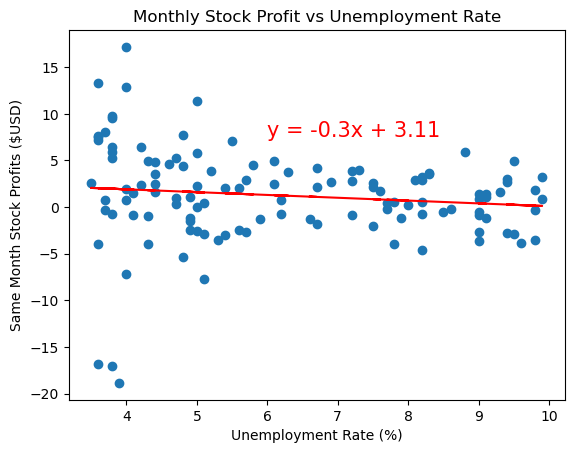

In [7]:
# Combine both data frames
combined_df = pd.merge(ticker_df, unemployment_data_df, how='inner', on=['Year','Month'])

# Add the linear regression equation and line to plot
x_values = combined_df['Rate']
y_values = combined_df['Monthly Profits']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Adjust the annotated location as required
plt.annotate(line_eq,(6,7.5),fontsize=15,color="red")
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Same Month Stock Profits ($USD)')
plt.title(f'Monthly Stock Profit vs Unemployment Rate')

# Print the r squared value
print(f"The r-squared is: {round(rvalue**2, 2)}")
print(f'The p-value is {round(pvalue, 2)}')

# The next example will compute the Pearson correlation coefficient between "Same Month Stock Profits" and "Unemployment Rate"
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")

# Save the figure
plt.savefig('output_data/04.Monthly_Profit_Unemployment_Graph.png')

# Show plot
plt.show()